# Mask R-CNN - Test on Shapes Dataset

Run the Mask R-CNN net in inference mode, with the additional PCILayer that generates the context-based tensor 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.shapes      import ShapesConfig
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_prototype import PCTensor
from mrcnn.pcn_layer    import PCNLayer, PCILayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
config.IMAGES_PER_GPU  = 1
config.display() 

# Build shape dataset        -----------------------------------------------

# from mrcnn.datagen import data_generator, load_image_gt

# Training dataset generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Detection

In [3]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display() 


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

### Build the model

In [4]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180502T1416\mask_rcnn_shapes_{epoch:04d}.h5

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> RPN Layer 
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     depth                   : 256
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     anchor_stride           : 1

>>> RPN Outputs  <class 'list'>
      rpn_class

In [5]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
print(' last weights file found:', model_path )
model_path  = 'E:\\Models\\mrcnn_logs\\shapes20180428T1819\\mask_rcnn_shapes_4809.h5'
print(' last weights to be used:', model_path )
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

 last weights file found: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_5335.h5
 last weights to be used: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_4809.h5
Loading weights from  E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_4809.h5
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_4809.h5
    load_weights: Log directory set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_4809.h5
>>> Set_log_dir() -- model dir is  E:\Models\mrcnn_logs
    set_log_dir: model_path (input) is : E:/Models/mrcnn_logs/shapes20180428T1819/mask_rcnn_shapes_4809.h5  
    set_log_dir: self.epoch set to 4810  (Next epoch to run)
    set_log_dir: tensorboard path: E:\Models\mrcnn_logs\tensorboard
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180428T1819\mask_rcnn_shapes_{epoch:04d}.h5
    Load weights complete


'E:\\Models\\mrcnn_logs\\shapes20180428T1819\\mask_rcnn_shapes_4809.h5'

###  Print some information about the model 

In [6]:
# model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# print('\n Metrics (_get_deduped_metrics_names():) ') 
# pp.pprint(mm._get_deduped_metrics_names())
# print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.metrics_names)
KB.set_learning_phase(1)
print(' Learning phase values is L ' ,KB.learning_phase())

print('\n Outputs: ') 
pp.pprint(model.keras_model.outputs)


 Learning phase values is L  1

 Outputs: 
[ <tf.Tensor 'mrcnn_detection/PyFunc:0' shape=<unknown> dtype=float32>,
  <tf.Tensor 'proposal_rois/packed_2:0' shape=(1, ?, ?) dtype=float32>,
  <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>,
  <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_class/Reshape_1:0' shape=(?, 1000, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_bbox/Reshape:0' shape=(?, 1000, 4, 4) dtype=float32>,
  <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 100, 28, 28, 4) dtype=float32>]


### Test on a random image

original_image           shape: (128, 128, 3)         min:    2.00000  max:  240.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_class_id              shape: (3, 4)                min:    0.00000  max:  128.00000
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  128.00000
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000


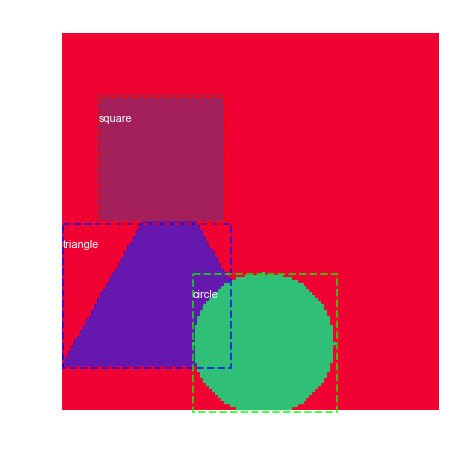

In [7]:
# Test on a random image
# Validation dataset
# dataset_val = shapes.ShapesDataset()
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.prepare()
from mrcnn.datagen import data_generator, load_image_gt
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [8]:
results = model.detect([original_image], verbose=1)

Processing 1 images
image                    shape: (128, 128, 3)         min:    2.00000  max:  240.00000
molded_images            shape: (1, 128, 128, 3)      min: -114.80000  max:  134.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000
    return from  predict()
    Length of detections :  1
    Length of rpn_rois   :  1
    Length of rpn_class  :  1
    Length of rpn_bbox   :  1
    Length of mrcnn_class:  1
    Length of mrcnn_bbox :  1
    Length of mrcnn_mask :  1


###  Detect()

In [13]:
# print('>>> model detect()')
verbose = 1
images  = [original_image]
assert model.mode   == "inference", "Create model in inference mode."
assert len(images) == model.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

if verbose:
    log("Processing {} images".format(len(images)))
    for image in images:
        log("image", image)

# Mold inputs to format expected by the neural network
molded_images, image_metas, windows = model.mold_inputs(images)
if verbose:
    log("molded_images", molded_images)
    log("image_metas"  , image_metas)

## Run object detection pipeline
# print('    call predict()')
detections, rpn_rois, rpn_class, rpn_bbox,\
            mrcnn_class, mrcnn_bbox, mrcnn_mask \
                      =  model.keras_model.predict([molded_images, image_metas], verbose=0)

print('    return from  predict()')
print('    Length of detections : ', len(detections))
print('    Length of rpn_rois   : ', len(rpn_rois   ))
print('    Length of rpn_class  : ', len(rpn_class  ))
print('    Length of rpn_bbox   : ', len(rpn_bbox   ))
print('    Length of mrcnn_class: ', len(mrcnn_class))
print('    Length of mrcnn_bbox : ', len(mrcnn_bbox ))
print('    Length of mrcnn_mask : ', len(mrcnn_mask ))

####  detection array layout is `[ y1, x1, y2, x2, class, score]`

detections[0].shape
print(detections[0])

## Process detections
results = []
for i, image in enumerate(images):
    final_rois, final_class_ids, final_scores, final_masks =\
        model.unmold_detections(detections[i], 
                               mrcnn_mask[i],
                               image.shape  ,
                               windows[i])
    results.append({
        "rois"     : final_rois,
        "class_ids": final_class_ids,
        "scores"   : final_scores,
        "masks"    : final_masks,
    })

Processing 1 images
image                    shape: (128, 128, 3)         min:   17.00000  max:  254.00000
molded_images            shape: (1, 128, 128, 3)      min:  -99.80000  max:  145.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


  rois       :  [[ 81  45 128  93]
 [ 20  12  64  55]
 [ 61   2 118  60]]
  masks      :  (128, 128, 3)
  class ids  :  [1 2 3]
  class names:  ['BG', 'circle', 'square', 'triangle']
  scores     :  [0.9999832 0.9992969 0.954553 ]


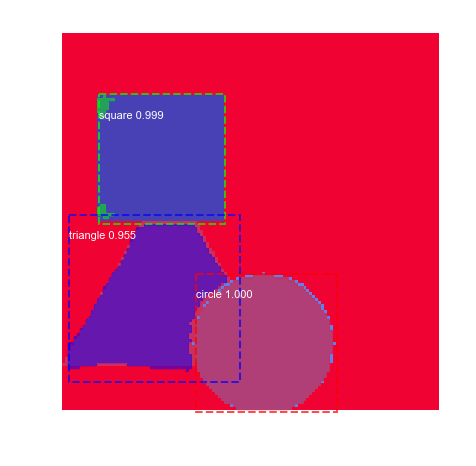

In [9]:
r = results[0]
print('  rois       : ', r['rois'])
print('  masks      : ', r['masks'].shape)
print('  class ids  : ', r['class_ids'])
print('  class names: ', dataset_val.class_names)
print('  scores     : ', r['scores'])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
from mrcnn.datagen     import data_generator, load_image_gt
import  mrcnn.utils as utils 

image_ids = np.random.choice(dataset_val.image_ids, 75)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(utils.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0


### Get next shapes from generator and display loaded shapes

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configurations

In [ ]:
# from keras import backend as KB
# if 'tensorflow' == KB.backend():
#     import tensorflow as tf
#     from keras.backend.tensorflow_backend import set_session
#     # tfconfig = tf.ConfigProto(
#         # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5),
#         # device_count = {'GPU': 1}
#     # )    
#     tfconfig = tf.ConfigProto()
#     tfconfig.gpu_options.allow_growth=True
#     tfconfig.gpu_options.visible_device_list = "0"
#     tfconfig.gpu_options.per_process_gpu_memory_fraction=0.5
#     tf_sess = tf.Session(config=tfconfig)
#     set_session(tf_sess)